**Prediction of Wine Quality based on its Manufacturing Ingredients**

## 1. Data Importing and Initial Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from pprint import pprint
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay


In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [ ]:
df =  pd.read_csv('https://raw.githubusercontent.com/rjrahul24/AppliedML-Project/main/winequalityN.csv',sep = ",")
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 2. Data Split and Preparation

In [ ]:
qualities = ['best', 'good', 'average', 'poor']
def quality_to_label(x):
  if x<=4:
    return 'poor'
  elif x > 4 and x<=6:
    return 'average'
  elif x > 6 and x<=8:
    return 'good'
  else:
    return 'best'

In [ ]:
X = df[['type', 'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density','pH','sulphates','alcohol']]
# y = df.quality.apply(lambda x:quality_to_label(x))
y = [1 if x >=7 else 0 for x in df['quality']]

# Split into Dev (80%) and Test (20%) Datasets, Random Forest doesn't need separate validation dataset
X_dev, X_test, y_dev, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42, stratify=y)


In [ ]:
t = df['quality']
t.value_counts()

6    2820
5    2128
7    1074
4     214
8     192
3      30
9       5
Name: quality, dtype: int64

**PreProcessing**

No scaling needed for random forest.

## 3. Model Selection, Training
### Dummy Classifier
To define baseline performance, we began with a dummy classifier. 

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy='most_frequent',random_state=42)
dummy_classifier.fit(X_dev,y_dev)
acc_baseline = dummy_classifier.score(X_test,y_test)
print("Baseline Accuracy = ", acc_baseline)

Baseline Accuracy =  0.8035576179427688


### Random Forest
No tuning


In [ ]:
rf = RandomForestClassifier(n_jobs = -1)
rf.fit(X_dev, y_dev)

RandomForestClassifier(n_jobs=-1)

In [ ]:
rf_pred = rf.predict(X_test)

recall = recall_score(y_test,rf_pred,average="micro")
precision = precision_score(y_test,rf_pred,average="micro")

print(f'Accuracy: {accuracy_score(y_test,rf_pred)}')
print(f'Recall: {recall_score(y_test,rf_pred,average="micro")}')
print(f'Precision: {precision_score(y_test,rf_pred,average="micro")}')
print(f'F-1 Score: {f1_score(y_test,rf_pred,average="micro")}')

Accuracy: 0.888631090487239
Recall: 0.888631090487239
Precision: 0.888631090487239
F-1 Score: 0.888631090487239


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


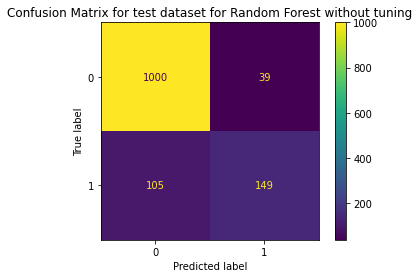

In [ ]:
# Making the Confusion Matrix
plot_confusion_matrix(rf, X_test, y_test)  
plt.title("Confusion Matrix for test dataset for Random Forest without tuning")
plt.show()

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Tuning hyperparameters

In [ ]:
parameter_grid = {'n_estimators':[100, 250, 400],
                  'max_depth':[5, 10, 15]}

rf_2 = make_pipeline(
    GridSearchCV(RandomForestClassifier(n_jobs = -1,warm_start=True), 
                 parameter_grid, 
                 cv=5, 
                 n_jobs=-1
                 )
)

rf_2.fit(X_dev, y_dev)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(n_jobs=-1,
                                                               warm_start=True),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10, 15],
                                          'n_estimators': [100, 250, 400]}))])

In [ ]:
rf_2_grid_search_results = rf_2.named_steps['gridsearchcv']

print(f'Best Score:{rf_2_grid_search_results.best_score_:0.5f}')
print(f'Best Params:{rf_2_grid_search_results.best_params_ }')
print(f'Test score:{rf_2.score(X_test,y_test):0.5f}')

Best Score:0.87988
Best Params:{'max_depth': 15, 'n_estimators': 400}
Test score:0.89559


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


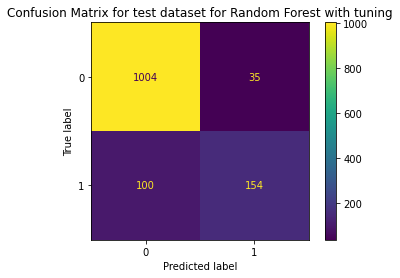

In [ ]:
# Making the Confusion Matrix
plot_confusion_matrix(rf_2, X_test, y_test)  
plt.title("Confusion Matrix for test dataset for Random Forest with tuning")
plt.show()

### XGBoost

In [ ]:
# start3 = time.time()
parameter_grid = {'n_estimators':[100, 250, 400],
                  'max_depth':[5, 10, 15],
                  'learning_rate':[0.05,0.1,0.15]}

xgb = make_pipeline(
    GridSearchCV(XGBClassifier(n_jobs = -1, warm_start=True), 
                 parameter_grid, 
                 cv=5, 
                 n_jobs=-1))

xgb.fit(X_dev, y_dev)
# end3 = time.time()

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(n_jobs=-1,
                                                      warm_start=True),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.05, 0.1, 0.15],
                                          'max_depth': [5, 10, 15],
                                          'n_estimators': [100, 250, 400]}))])

In [ ]:
grid_search_XGB = xgb.named_steps["gridsearchcv"]
print(f'XGBoost Best Score:{grid_search_XGB.best_score_:0.5f}')
print(f'XGBoost Best Params:{grid_search_XGB.best_params_ }')
print(f'XGBoost Test score:{xgb.score(X_test,y_test):0.5f}')

XGBoost Best Score:0.87911
XGBoost Best Params:{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 250}
XGBoost Test score:0.89172


In [ ]:
xgb_y_pred = xgb.predict(X_test)
recall = recall_score(y_test,xgb_y_pred), 
precision = precision_score(y_test,xgb_y_pred)
print(f'Accuracy: {accuracy_score(y_test,xgb_y_pred)}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F-1 Score: {f1_score(y_test,xgb_y_pred)}')

Accuracy: 0.8917246713070379
Recall: (0.6023622047244095,)
Precision: 0.796875
F-1 Score: 0.6860986547085203


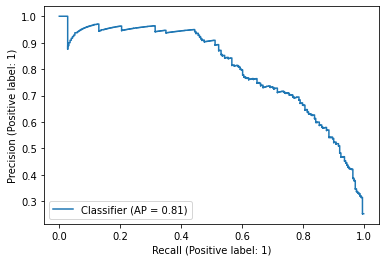

In [ ]:
probs = xgb.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision);